In [1]:
# run in the root of the repository
%load_ext autoreload
%autoreload 2
 
%cd ../..

/private/home/pfz/09-videoseal/videoseal-dev


In [2]:
from videoseal.utils.display import save_img
from videoseal.utils import Timer
from videoseal.evals.full import setup_model_from_checkpoint
from videoseal.evals.metrics import bit_accuracy, psnr, ssim
from videoseal.augmentation import Identity, JPEG
from videoseal.modules.jnd import JND, VarianceBasedJND


import os
import omegaconf
from tqdm import tqdm
import gc
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision

to_tensor = torchvision.transforms.ToTensor()
to_pil = torchvision.transforms.ToPILImage()

device = "cpu" 

/private/home/pfz/miniconda3/envs/img/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/private/home/pfz/miniconda3/envs/img/lib/python3.13/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


Model loaded successfully from /checkpoint/pfz/2025_logs/0306_vseal_ydisc_release_bis/_nbits=256/checkpoint600.pth with message: <All keys matched successfully>
{'file': '/private/home/pfz/_images/tahiti.png', 'bit_accuracy': 1.0, 'psnr': 47.43052673339844, 'ssim': 0.9985253214836121}


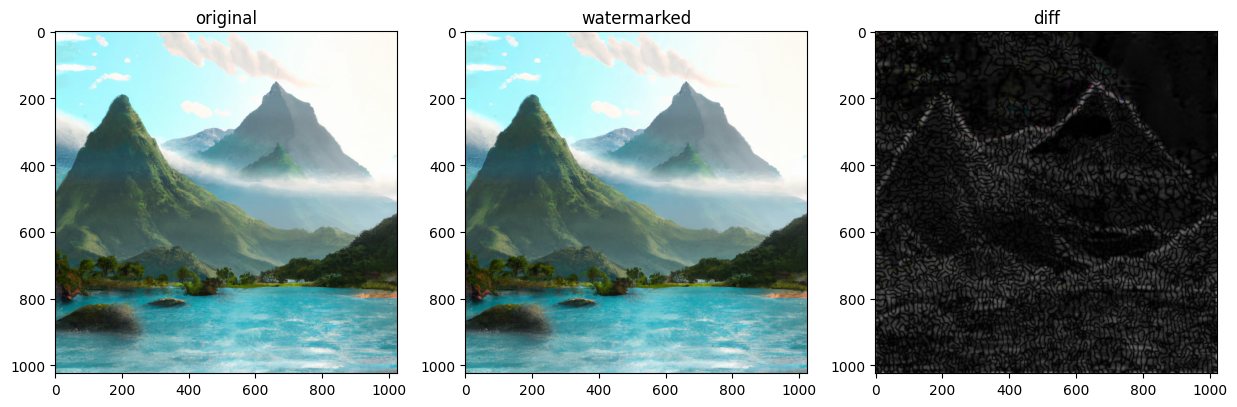

In [6]:
# Directory containing videos
num_imgs = 10
assets_dir = "assets/imgs"
base_output_dir = "outputs"
os.makedirs(base_output_dir, exist_ok=True)

ckpt = "/checkpoint/pfz/2025_logs/0306_vseal_ydisc_release_bis/_nbits=256/checkpoint600.pth"
wam = setup_model_from_checkpoint(ckpt)
wam.blender.scaling_w = 0.2
wam.eval()
wam.to(device)
    
# wam.compile()

# Iterate over all video files in the directory
file = "/private/home/pfz/_images/tahiti.png"
imgs = Image.open(file, "r").convert("RGB")  # keep only rgb channels
imgs = to_tensor(imgs).unsqueeze(0).float()

# Watermark em
outputs = wam.embed(imgs, is_video=False, lowres_attenuation=True)
torch.cuda.synchronize()
# print(f"embedding watermark  - took {timer.stop():.2f}s")

# compute diff
imgs_w = outputs["imgs_w"]  # b c h w
msgs = outputs["msgs"]  # b k
diff = (imgs_w - imgs).abs() * 25

# save
imgs_aug = imgs_w
outputs = wam.detect(imgs_aug, is_video=False)
preds = outputs["preds"]
metrics = {
    "file": file,
    "bit_accuracy": bit_accuracy(
        outputs["preds"][:, 1:],
        msgs
    ).nanmean().item(),
    "psnr": psnr(imgs_w, imgs).item(),
    "ssim": ssim(imgs_w, imgs).item()
}

# Augment video
# print(f"compressing and detecting watermarks")
# for qf in [80, 40]:
#     imgs_aug, _ = JPEG()(imgs_w, None,qf)

#     outputs = wam.detect(imgs_aug, is_video=True)
#     preds = outputs["preds"]
#     # print(preds)
#     bit_preds = preds[:, 1:]  # b k ...
#     bit_accuracy_ = bit_accuracy(
#         bit_preds,
#         msgs
#     ).nanmean().item()
    
#     metrics[f"bit_accuracy_qf{qf}"] = bit_accuracy_

print(metrics)

# plot img, imgs_w, diff
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(imgs.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("original")
plt.subplot(1, 3, 2)
plt.imshow(imgs_w.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("watermarked")
plt.subplot(1, 3, 3)
plt.imshow(diff.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("diff")
plt.show()

### Trace

In [4]:
# create trace for embedder

class EmbedderWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, imgs, msgs):
        return self.model.embed(imgs, msgs, is_video=False, lowres_attenuation=True)["imgs_w"]

In [5]:
embedder_tr = EmbedderWrapper(wam)
embedder_tr.eval()

embedder_tr = torch.jit.trace(embedder_tr, (imgs, msgs))
torch.jit.save(embedder_tr, "outputs/embedder.pt")

/private/home/pfz/09-videoseal/videoseal-dev/videoseal/models/wam.py:162: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if imgs.shape[-2:] != (self.img_size, self.img_size):
/private/home/pfz/09-videoseal/videoseal-dev/videoseal/modules/unet.py:224: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  nb_imgs: int = len(imgs)
/private/home/pfz/09-videoseal/videoseal-dev/videoseal/modules/msg_processor.py:107: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently

In [6]:
# print size
print(f"Size of the model: {os.path.getsize(ckpt) / 1e6:.2f} MB")
print(f"Size of the model: {os.path.getsize('outputs/embedder.pt') / 1e6:.2f} MB")

# load 
# num params in embedder
print(f"Number of parameters in embedder: {sum(p.numel() for p in wam.embedder.parameters())/ 1024 / 1024} ")

embedder_tr = torch.jit.load("outputs/embedder.pt")
imgs_w_tr = embedder_tr(imgs, msgs)

# check that the output is the same
diff = (imgs_w - imgs_w_tr).abs()
print(f"diff: {diff.mean().item()}")


Size of the model: 686.84 MB
Size of the model: 228.81 MB
Number of parameters in embedder: 22.56428623199463 
diff: 0.0


### Torchscript


In [4]:
device = "cpu"
ckpt = "/checkpoint/pfz/2025_logs/0306_vseal_ydisc_release_bis/_nbits=256/checkpoint600.pth"
wam = setup_model_from_checkpoint(ckpt)
wam.blender.scaling_w = 0.2
wam.eval()
wam.to(device)

from videoseal.models.wam_jit import WamJIT

model_jit = WamJIT(wam.embedder, wam.detector, wam.attenuation, 0.2, 1.0)
model_jit.eval()
model_jit = torch.jit.script(model_jit)
model_jit.save("outputs/wam_jit.pt")
print(f"Saved model to outputs/wam_jit.pt")
print(f"Size of the model: {os.path.getsize('outputs/wam_jit.pt') / 1e6:.2f} MB")

# test 
model_jit = torch.jit.load("outputs/wam_jit.pt")
imgs_w_jit, preds = model_jit(imgs, msgs)
diff = (imgs_w - imgs_w_jit).abs()
print(f"diff: {diff.mean().item()}")

Model loaded successfully from /checkpoint/pfz/2025_logs/0306_vseal_ydisc_release_bis/_nbits=256/checkpoint600.pth with message: <All keys matched successfully>
Saved model to outputs/wam_jit.pt
Size of the model: 228.51 MB
diff: 0.0


Model loaded successfully from /checkpoint/pfz/2025_logs/0306_vseal_ydisc_release_bis/_nbits=256/checkpoint600.pth with message: <All keys matched successfully>
Converting model to TorchScript...
Saved model to outputs/wam_jit.pt
Size of the model: 228.52 MB
Testing model...
Mean absolute difference: 0.0
Max absolute difference: 0.0
✅ Test passed: JIT model produces the same outputs as the original model


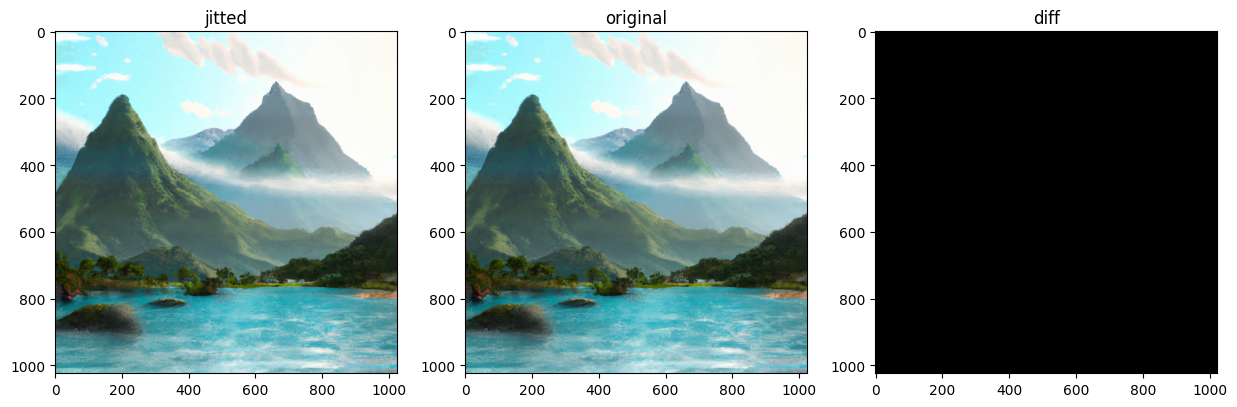

Original model bit accuracy: 1.0
JIT model bit accuracy: 1.0
Mean absolute difference in predictions: 0.0
Max absolute difference in predictions: 0.0
✅ Test passed: JIT model produces the same predictions as the original model


In [ ]:
import os
import torch
from PIL import Image
from torchvision.transforms.functional import to_tensor

from videoseal.evals.full import setup_model_from_checkpoint
from videoseal.models.wam_jit import WamJIT

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load image
file = "/private/home/pfz/_images/tahiti.png"
imgs = Image.open(file, "r").convert("RGB")  # keep only rgb channels
imgs = to_tensor(imgs).unsqueeze(0).float()

# Generate random message
msgs = torch.randint(0, 2, (1, 256))

# Move to device
imgs = imgs.to(device)
msgs = msgs.to(device)

# Load model from checkpoint
ckpt = "/checkpoint/pfz/2025_logs/0306_vseal_ydisc_release_bis/_nbits=256/checkpoint600.pth"

# Setup model from checkpoint and configure
wam = setup_model_from_checkpoint(ckpt)
wam.blender.scaling_w = 0.2
wam.eval()
wam.to(device)

# Create JIT version
model_jit = WamJIT(
    wam.embedder, 
    wam.detector, 
    wam.attenuation, 
    scaling_w=0.2, 
    scaling_i=1.0
)
model_jit.eval()
model_jit.to(device)

# Script the model
print("Converting model to TorchScript...")
model_jit = torch.jit.script(model_jit)
model_jit.save("outputs/wam_jit.pt")
print(f"Saved model to outputs/wam_jit.pt")
print(f"Size of the model: {os.path.getsize('outputs/wam_jit.pt') / 1e6:.2f} MB")

# Test - Compare original and JIT models
print("Testing model...")

# Run original model
imgs_w = wam.embed(imgs, msgs, lowres_attenuation=True)["imgs_w"]

# Load JIT model and run
model_jit = torch.jit.load("outputs/wam_jit.pt")
imgs_w_jit = model_jit.embed(imgs, msgs)["imgs_w"]

# Compare results
diff = (imgs_w - imgs_w_jit).abs()
print(f"Mean absolute difference: {diff.mean().item()}")
print(f"Max absolute difference: {diff.max().item()}")

if diff.mean().item() < 1e-5:
    print("✅ Test passed: JIT model produces the same outputs as the original model")
else:
    print("❌ Test failed: JIT model produces different outputs than the original model")

# plot the diff between the original and JIT model
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(imgs_w_jit.detach().squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("jitted")
plt.subplot(1, 3, 2)
plt.imshow(imgs_w.detach().squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("original")
plt.subplot(1, 3, 3)
diff = (imgs_w - imgs_w_jit).abs() * 25
plt.imshow(diff.detach().squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("diff")
plt.show()

# compare detection results
# Run original model detection
outputs = wam.detect(imgs_w, is_video=False)
preds = outputs["preds"]
bit_preds = preds[:, 1:]  # b k ...
bit_accuracy_ = bit_accuracy(
    bit_preds,
    msgs
).nanmean().item()
print(f"Original model bit accuracy: {bit_accuracy_}")
# Run JIT model detection
outputs_jit = model_jit.detect(imgs_w, is_video=False)
preds_jit = outputs_jit["preds"]
bit_preds_jit = preds_jit[:, 1:]  # b k ...
bit_accuracy_jit = bit_accuracy(
    bit_preds_jit,
    msgs
).nanmean().item()
print(f"JIT model bit accuracy: {bit_accuracy_jit}")

# orint diff between preds_jit and preds
diff = (preds - preds_jit).abs()
print(f"Mean absolute difference in predictions: {diff.mean().item()}")
print(f"Max absolute difference in predictions: {diff.max().item()}")
if diff.mean().item() < 1e-5:
    print("✅ Test passed: JIT model produces the same predictions as the original model")
else:
    print("❌ Test failed: JIT model produces different predictions than the original model")